In [34]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import pandas_ta as ta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import json

In [2]:

path = os.path.realpath('nasdaq_med_small.csv')


tickers = pd.read_csv(path)

sectors = list(pd.Series((tickers['Sector'].unique())).dropna())

ticks = {sec : [] for sec in sectors}

for sec in sectors:
    
    ticks[sec] = tickers['Symbol'].loc[ tickers['Sector'] == sec].to_list()


sec_data = {sec: yf.download(ticks[sec], start = '2012-01-01')['Close'].dropna(axis=1) for sec in sectors}


[*********************100%***********************]  383 of 383 completed
[*********************100%***********************]  92 of 92 completed
[*********************100%***********************]  29 of 29 completed
[*********************100%***********************]  339 of 339 completed
[*********************100%***********************]  289 of 289 completed
[*********************100%***********************]  47 of 47 completed
[*********************100%***********************]  135 of 135 completed
[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  28 of 28 completed
[*********************100%***********************]  26 of 26 completed
[*********************100%***********************]  59 of 59 completed
[*********************100%***********************]  36 of 36 completed


In [3]:
ok = []
for sec in sec_data:
    
    if len(sec_data[sec].columns) == 0:
        ok.append(sec)

for sec in ok:
    sec_data.pop(sec)
    
    
for sec in sec_data:
    
    sec_data[sec]['nasdaq'] = yf.download('^IXIC', start = '2012-01-01', progress = False)['Close']

In [24]:

hedges = {sec : sec_data[sec].cov()['nasdaq'].sort_values()[:6] for sec in sec_data}
hedges.keys()

dict_keys(['Health Care', 'Capital Goods', 'Transportation', 'Finance', 'Technology', 'Consumer Durables', 'Consumer Services', 'Public Utilities', 'Basic Industries', 'Energy', 'Consumer Non-Durables', 'Miscellaneous'])

In [25]:
sector_of_interest = 'Finance'

balance = {'Assets': {c : 0.0 for c in hedges[sector_of_interest].index},
           'Liabilities': {c : 0.0 for c in hedges[sector_of_interest].index},
           'Equity': {c : 0.0 for c in hedges[sector_of_interest].index}}


assets = {c : {} for c in hedges[sector_of_interest].index}
liabilities = {c : {} for c in hedges[sector_of_interest].index}
equity = {c : {} for c in hedges[sector_of_interest].index}

assets = []
liabilities = []
equity = []

for c in hedges[sector_of_interest].index:
    
    print(c)
    tick = yf.Ticker(c)

    sheet = tick.balance_sheet.T
    
    asset_i = sheet['Total Assets'].iloc[0]
    #assets[c] = asset_i
    
    liabilities_i = sheet['Total Current Liabilities'].iloc[0]
    #liabilities[c] = liabilities_i
    
    equity_i = sheet['Total Stockholder Equity'].iloc[0]
    #equity[c] = equity_i
    
    assets.append(asset_i)
    liabilities.append(liabilities_i)
    equity.append(equity_i)


GREE
AINV
OXLC
CSWC
WETF
CRESY


In [36]:
vod = yf.Ticker('GRPN')

b_sheet = vod.balance_sheet.T

b_sheet['Total Current Liabilities'][0]/b_sheet['Total Assets'][0]

0.5449497832678833

In [40]:
vod.get_info()['ebitda']

110059000

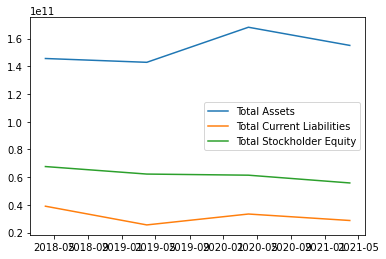

In [33]:

plt.plot(b_sheet.index, b_sheet['Total Assets'])
plt.plot(b_sheet.index, b_sheet['Total Current Liabilities'])
plt.plot(b_sheet.index, b_sheet['Total Stockholder Equity'])
plt.legend(['Total Assets', 'Total Current Liabilities', 'Total Stockholder Equity'])

In [27]:
import plotly.graph_objects as go

companies = list(hedges[sector_of_interest].index)[:-1]
#companies contains our list of firms e.g. ['ABBV', 'AGN'..]

fig = go.Figure(data=[
    go.Bar(name='Assets', x=companies, y=assets ),
    go.Bar(name='Liabilities', x=companies, y=liabilities),
    go.Bar(name='Equity', x=companies, y=equity)
])

fig.update_layout(barmode='stack',title = 'Balance Sheet Latest Quarter')
fig.show()